In [29]:

import warnings
warnings.filterwarnings("ignore")

import os,sys

sys.path.append(os.path.abspath(os.path.join('C:\Work\WORK_PACKAGE\Demand_forecasting\github\DeepAR-pytorch\My_model\\2_freq_nbinom_LSTM')))

sys.path.append(os.path.abspath(os.path.join('C:\Work\WORK_PACKAGE\Demand_forecasting\github\DeepAR-pytorch\My_model\\2_freq_nbinom_LSTM\\1_cluster_demand_prediction\data\weather_data')))
sys.path.append(os.path.abspath(os.path.join('C:\Work\WORK_PACKAGE\Demand_forecasting\github\DeepAR-pytorch\My_model\2_freq_nbinom_LSTM\1_cluster_demand_prediction\data\demand_data')))



from pytorch_forecasting.data.encoders import TorchNormalizer

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
from pytorch_forecasting.data import TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
import pytorch_lightning as pl
from pytorch_forecasting import NegativeBinomialDistributionLoss, DeepAR
import torch
from pytorch_forecasting.data.encoders import TorchNormalizer
import os,sys
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import acf,pacf
from scipy.signal import find_peaks
import operator
import statsmodels.api as sm
from itertools import combinations
import pickle

In [31]:
"""
set inputs here

"""

chosen_clstr = 'clstr_175' # response cluster

In [32]:
"""
Data Visulaization

"""

########## Read DATA  start ######################

########## Weather data ##########
tampines_region_weather =  pd.read_csv('C:\Work\WORK_PACKAGE\Demand_forecasting\github\DeepAR-pytorch\My_model\\2_freq_nbinom_LSTM\\1_cluster_demand_prediction\data\weather_data\\tampines_clstr_175_weather.csv')

temp_clstr_175 = tampines_region_weather["temp_clstr_175"]
hum_clstr_175 = tampines_region_weather["hum_clstr_175"]
wind_clstr_175 = tampines_region_weather["wind_clstr_175"]
wea_clstr_175 = tampines_region_weather["wea_clstr_175"]
wea_desc_clstr_175 = tampines_region_weather["wea_desc_clstr_175"]
########## Weather data ##########



########## demand data clusters ##########
tampines_region_demand =  pd.read_csv('C:\Work\WORK_PACKAGE\Demand_forecasting\github\DeepAR-pytorch\My_model\\2_freq_nbinom_LSTM\\1_cluster_demand_prediction\data\demand_data\\tampines_region_demand.csv')
col_names = list(tampines_region_demand.columns)
reg_dem = {}
for c in col_names:
    reg_dem[c] =  tampines_region_demand[c]
########## demand data clusters ##########

########## Read DATA  end ######################




########## Visualize DATA  start ######################

########## Visualize Weather DATA  ######################
# plt.plot(temp_clstr_175)
# plt.ylabel("temperature/kelvin")
# plt.show()

# plt.plot(hum_clstr_175)
# plt.ylabel("humidity/%")
# plt.show()

# plt.plot(wind_clstr_175)
# plt.ylabel("wind/ (m/s)")
# plt.show()

# plt.plot(wea_clstr_175)
# plt.ylabel("weather brief")
# plt.show()

# plt.plot(wea_desc_clstr_175)
# plt.ylabel("weather detailed")
# plt.show()
########## Visualize Weather DATA  ######################

########## Visualize demand DATA  ######################
# for c in col_names:
#     reg_dem[c] =  tampines_region_demand[c]
#     plt.plot(reg_dem[c])
#     plt.ylabel(f"cluster {c}")
#     plt.show()
########## Visualize demand DATA  ######################

########## Visualize DATA  end ######################

In [33]:
######## combine all numerical time series into a dictionary ##########
all_num_ts = {'temp_clstr_175':temp_clstr_175,'hum_clstr_175':hum_clstr_175, 'wind_clstr_175':wind_clstr_175}
for c in col_names:
    all_num_ts['clstr_'+c] = reg_dem[c]
######## combine all numerical time series into a dictionary ##########


In [34]:
"""
Data Analysis

# Need to check stationarity of all covariates.
# we do not stationarize non-stationary time series immediately,
# we do only if test error for the
# cluster is bad
"""

###### Check staionarity of ALL numerical time series ###### 
cov_stationary_flag = {}
col_names = all_num_ts.keys()

for c in col_names:
	result = adfuller(all_num_ts[c])
	if result[0] < (result[4]["1%"] and result[4]["5%"] and result[4]["10%"] ):
		cov_stationary_flag[c] = 1 # stationary
	else:
		cov_stationary_flag[c] = 0		

print('stationarity: ',cov_stationary_flag)
###### Check staionarity of ALL numerical time series ###### 

stationarity:  {'temp_clstr_175': 1, 'hum_clstr_175': 1, 'wind_clstr_175': 1, 'clstr_126': 1, 'clstr_166': 1, 'clstr_167': 1, 'clstr_168': 1, 'clstr_169': 1, 'clstr_170': 1, 'clstr_171': 1, 'clstr_172': 1, 'clstr_173': 1, 'clstr_174': 1, 'clstr_175': 1}


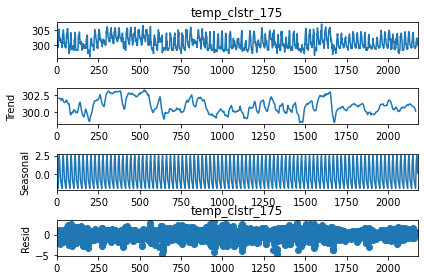

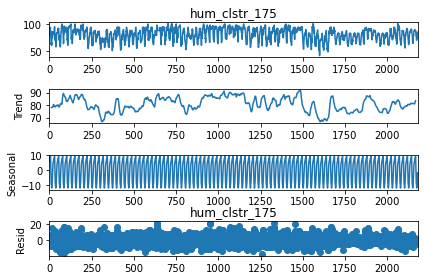

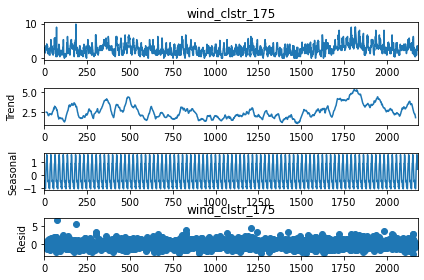

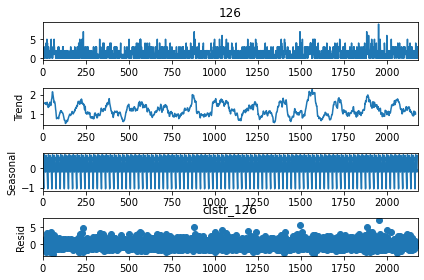

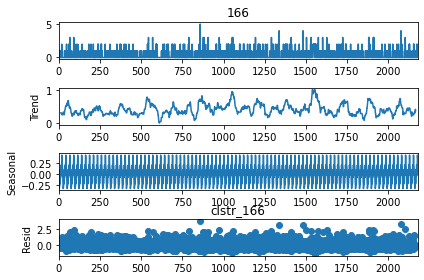

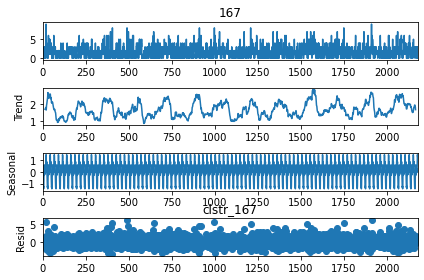

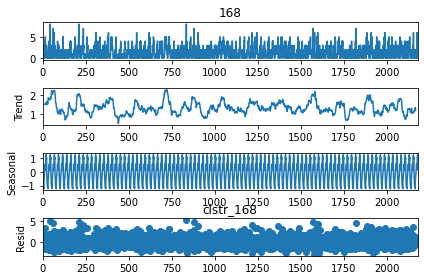

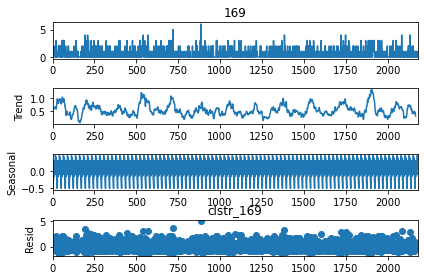

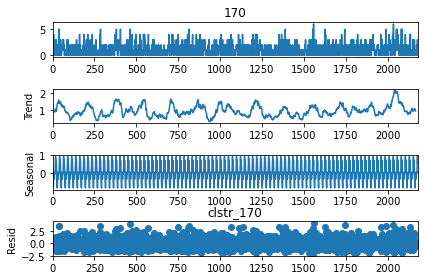

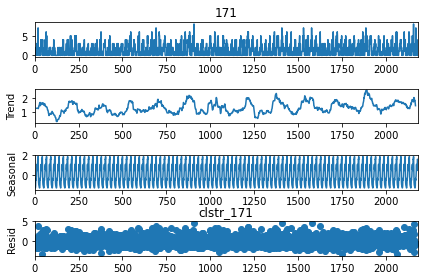

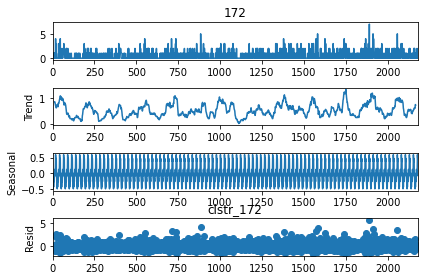

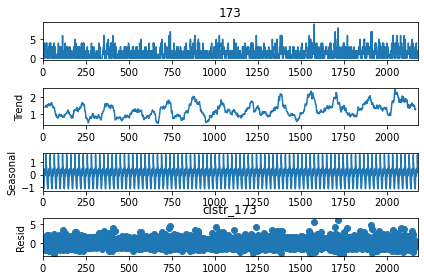

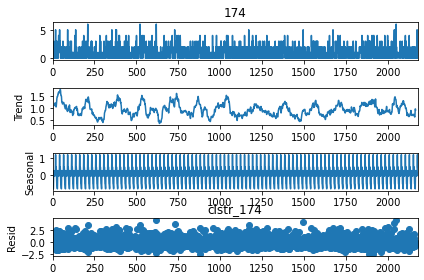

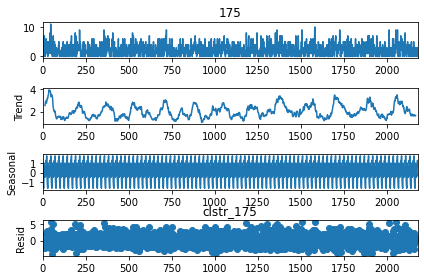

In [35]:
##### Decompose ALL numerical time series ###### 
for c in col_names:
    add = seasonal_decompose(all_num_ts[c], model='additive', period=24)
    add.plot()
    plt.title(c)
    plt.show()
    ## mul = seasonal_decompose(all_num_ts[c], model='multiplicative', period=1)
    ## mul.plot()
    ## plt.show()
##### Decompose ALL numerical time series ###### 

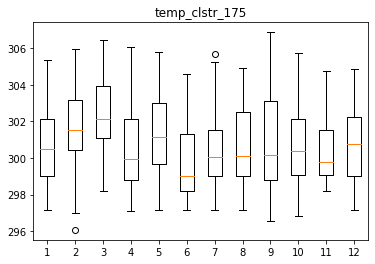

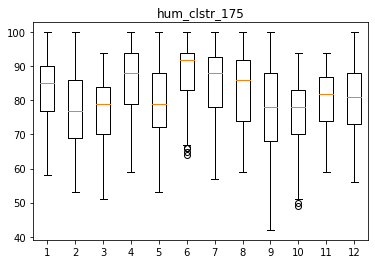

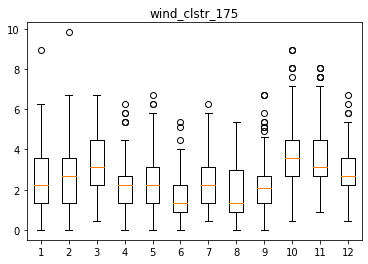

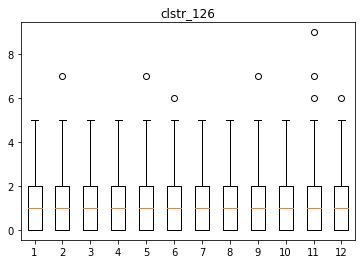

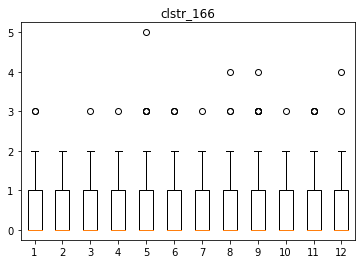

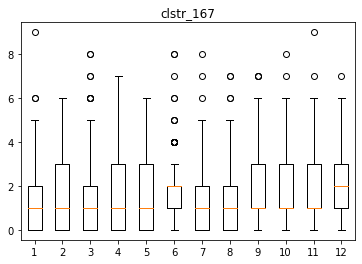

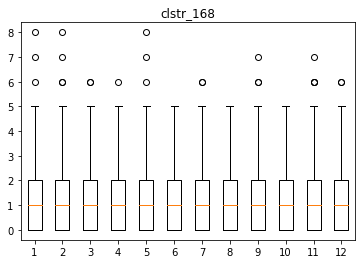

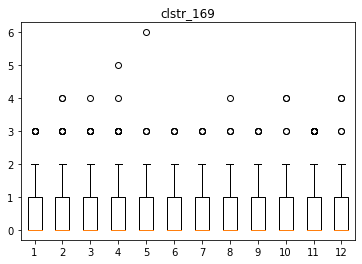

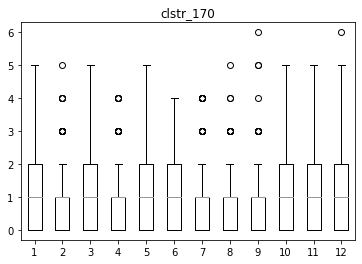

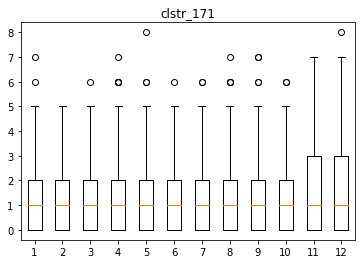

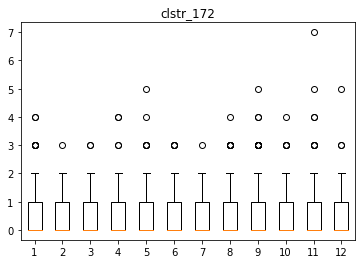

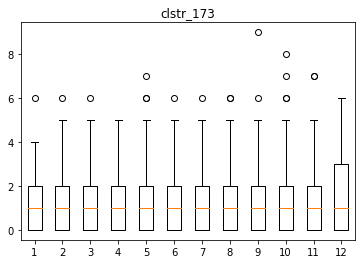

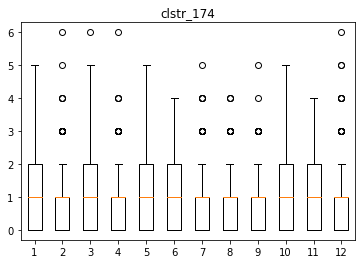

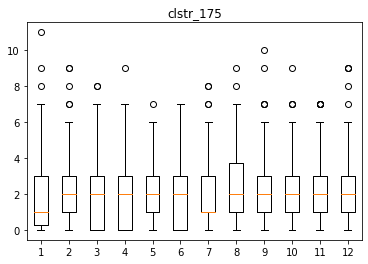

In [36]:
##### box plot of ALL numerical time series ###### 
win_size = 168
for c in col_names:
    ts_split = np.array_split(all_num_ts[c],len(all_num_ts[c])//win_size)
    plt.boxplot(ts_split)
    plt.title(c)
    plt.show()
##### box plot of ALL numerical time series ###### 

peak index: []


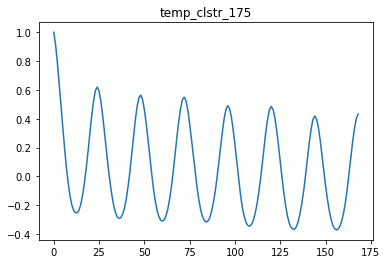

peak index: []


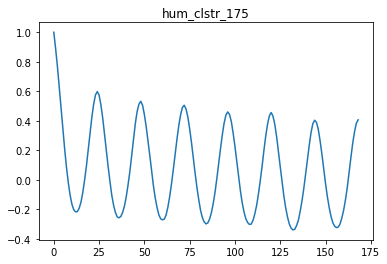

peak index: [ 12  36  60  84 108 132 156]


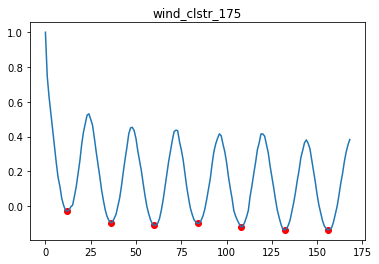

peak index: [  5   6   7   9  10  11  12  13  17  31  34  36  37  38  39  41  48  52
  53  55  58  59  61  65  67  68  72  78  79  80  81  82  83  84  85  90
  91  92  96 101 102 103 106 108 109 112 120 125 127 128 130 131 134 137
 144 148 149 151 155 157 158 161 162 163]


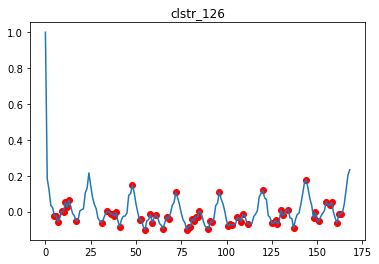

peak index: [  1   3   6   7   8   9  10  12  13  14  15  16  17  25  30  31  32  34
  35  36  37  40  41  42  43  44  45  47  48  49  57  60  61  63  65  67
  68  69  70  72  75  77  79  81  82  83  84  85  86  88  89  91  92  93
  94  95  96  97 104 106 107 109 110 111 112 115 117 119 120 122 125 126
 128 129 130 131 133 135 136 138 139 143 144 145 146 147 148 149 151 154
 155 157 160 162 163 165 166]


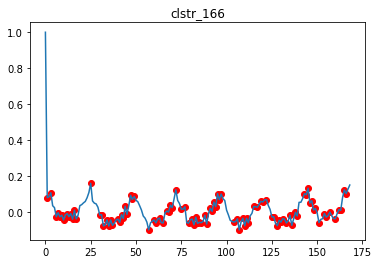

peak index: [  7  12  13  14  15  31  33  34  35  36  37  40  48  55  57  58  59  60
  62  65  72  79  80  81  82  84  85  89  96 103 107 108 109 110 111 113
 127 132 133 134 136 151 152 153 155 160]


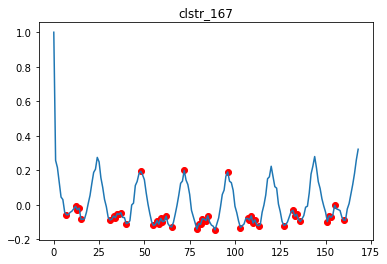

peak index: [  8   9  11  12  14  35  80  81  86  87 131 133 134 151 152 155 157 159]


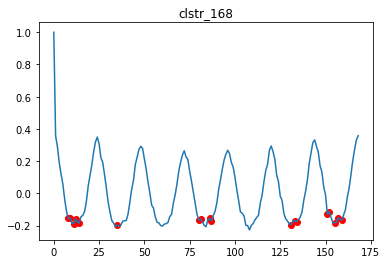

peak index: [  6  10  11  12  15  16  17  19  20  24  32  34  37  39  40  48  49  50
  55  58  61  62  64  66  67  70  71  72  73  74  76  77  80  81  82  83
  85  86  87  88  89  90  91  93  94  96  99 100 101 102 103 105 107 108
 110 112 113 114 116 119 120 121 123 124 126 130 131 132 133 136 137 139
 140 142 143 144 145 146 150 152 153 155 156 157 158 159 161 162 163 167]


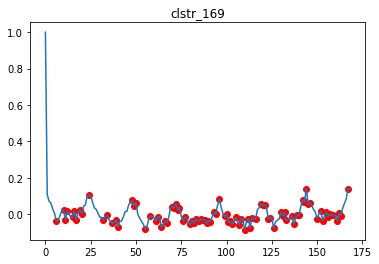

peak index: [  4   5   7   8   9  10  11  12  13  16  17  18  19  32  33  35  37  38
  39  40  44  45  49  58  59  60  61  62  64  65  68  70  73  76  77  81
  82  85  87  88  89  90  95 104 105 108 109 110 111 113 114 115 120 122
 123 124 125 129 130 133 135 136 144 152 153 154 158 159]


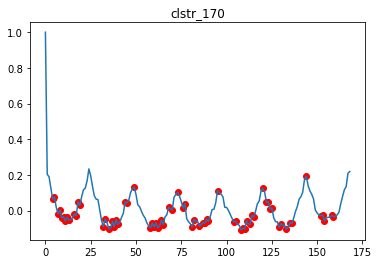

peak index: []


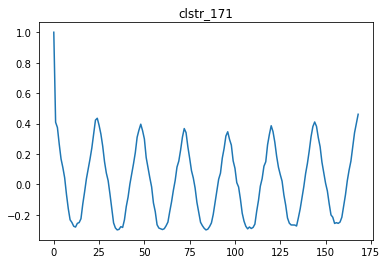

peak index: [  9  11  12  13  14  17  18  20  21  22  23  24  27  28  30  31  36  39
  40  46  47  48  51  52  56  57  61  62  63  70  71  72  74  75  79  80
  81  83  84  86  88  93  94  96  97  98  99 100 101 102 105 107 108 110
 111 120 124 125 127 128 129 130 131 134 135 137 138 143 144 145 154 155
 156 159 160]


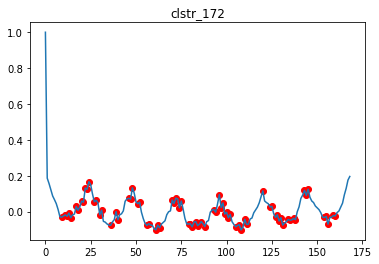

peak index: [  8   9  10  11  12  15  16  32  33  34  35  36  37  38  39  40  55  56
  57  58  60  62  63  67  68  72  80  81  82  84  85  86  88  95 104 105
 106 108 109 111 112 120 121 122 128 129 131 132 133 135 136 147 148 151
 152 153 154 155 159 160]


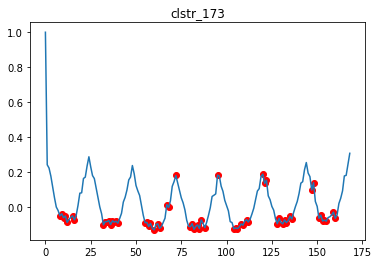

peak index: [  4   5   7  10  11  13  14  15  17  18  19  24  32  33  34  36  40  48
  55  57  59  62  65  72  74  75  79  81  82  83  84  85  87  90  91  92
  93  96 104 106 107 108 109 110 111 112 113 120 127 129 130 132 133 134
 135 136 137 151 152 153 155 156 157 158 159 161]


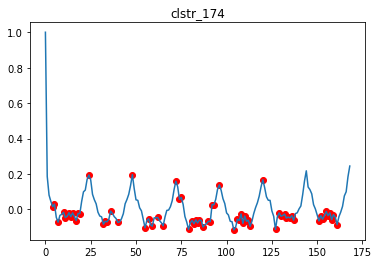

peak index: [  7  10  11  12  18  31  34  38  39  42  55  59  60  61  65  72  79  82
  83  84  85  86  90  96 102 106 109 110 114 127 132 133 134 137 151 155
 156 157 161]


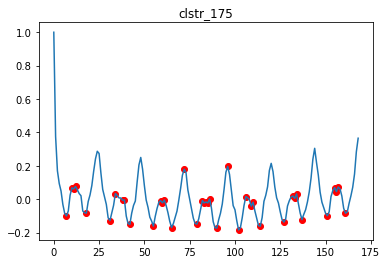

In [37]:
###### ACF plot of ALL numerical time series ###### 
peak_idx_acf = np.array([])
view_lags = 168
for c in col_names:
    acf1 = acf(all_num_ts[c], nlags=view_lags)
    peak_idx_high = np.array((find_peaks(acf1,height=(-0.2,0.2))[0]),dtype=int)
    peak_idx_low = np.array((find_peaks(-1*acf1,height=(-0.2,0.2))[0]),dtype=int)
    peak_idx_acf = np.sort(np.concatenate((peak_idx_high, peak_idx_low),axis=0))
    print(f'peak index: {peak_idx_acf}')
    x = list(range(0,len(acf1)))
    plt.plot(x,acf1)
    plt.scatter(peak_idx_high,acf1[peak_idx_high],color='red')
    plt.scatter(peak_idx_low,acf1[peak_idx_low],color='red')
    plt.title(c)
    plt.show()

# use peak_idx_acf to pick the first 50 lags

###### ACF plot of ALL numerical time series ###### 

peak index: [  2   4   5  11  13  20  25  27  28  29  32  34  35  36  37  41  42  43
  44  45  49  51  53  54  55  57  58  59  60  63  64  65  69  70  72  73
  75  76  77  78  79  80  81  83  84  87  88  90  91  92  93  94  97  98
  99 101 102 105 106 109 110 111 112 113 114 116 118 119 121 122 125 126
 127 128 129 131 133 135 136 137 138 140 142 143 145 147 148 149 150 151
 152 153 154 155 156 157 158 159 160 163 164 165 166 167]


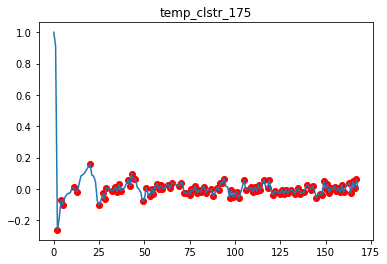

peak index: [  3   4   5   6   7  11  13  17  18  19  26  27  28  30  32  33  35  36
  37  38  39  41  42  43  44  45  47  48  49  51  52  53  54  56  58  59
  61  63  65  66  68  69  70  71  73  74  75  76  77  78  79  80  81  82
  84  85  88  90  92  94  97  98  99 100 102 104 108 110 112 113 115 116
 117 118 121 122 123 126 127 128 130 132 133 134 135 136 137 142 145 146
 147 148 149 152 153 155 156 159 160 161 162 163 164 165 166 167]


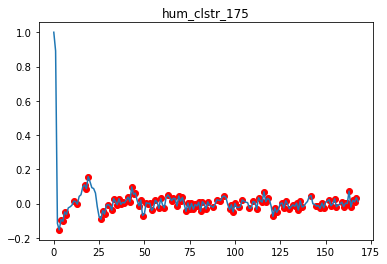

peak index: [  6   8   9  10  11  12  13  14  15  16  17  18  19  20  22  23  25  26
  28  29  31  32  34  35  36  38  39  40  41  43  44  46  51  53  54  55
  56  57  58  59  60  61  62  65  67  68  69  71  72  73  74  75  78  81
  82  83  85  86  87  88  89  90  91  92  94  96  98  99 101 103 104 105
 108 110 111 113 114 115 116 117 118 119 120 121 122 123 124 125 127 129
 131 132 133 134 135 136 137 138 140 141 142 143 145 146 147 148 149 152
 153 155 157 160 161 162 164 166 167]


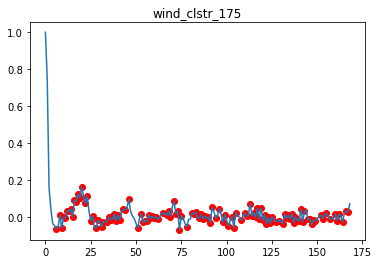

peak index: [  3   4   5   6   7   9  10  11  12  13  15  16  17  19  21  22  23  24
  30  34  36  37  38  39  41  42  44  46  47  48  52  53  55  56  57  58
  59  61  63  64  65  67  68  70  71  72  76  77  78  79  80  81  82  85
  88  89  90  91  92  94  95  96  97  98 100 102 105 106 108 109 111 115
 116 118 121 122 123 124 125 127 128 130 131 134 135 136 137 139 140 143
 146 147 148 149 151 153 154 155 157 158 161 162 164 167]


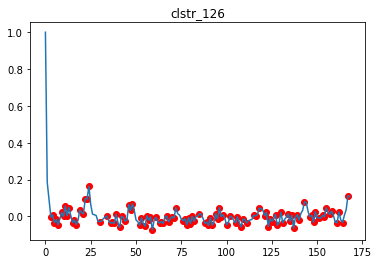

peak index: [  2   3   6   7   8   9  10  12  13  14  15  16  17  20  21  25  27  29
  30  31  32  34  35  36  37  40  41  42  43  44  45  47  48  49  50  51
  54  55  57  60  61  62  65  66  68  69  70  72  75  77  78  81  82  83
  84  85  86  88  89  91  92  93  94  95  96  97  98  99 102 105 107 109
 110 111 112 115 118 119 120 122 125 126 127 129 130 131 134 135 136 138
 139 140 144 145 146 147 148 149 151 154 160 162 163 165 166]


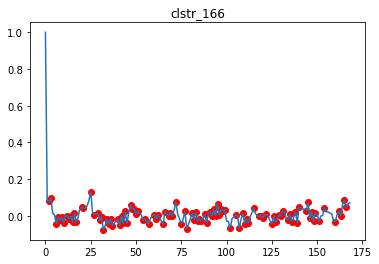

peak index: [  4   5   6   9  10  12  13  14  15  22  23  24  30  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  49  50  55  57  58  59  60  62
  64  70  71  72  73  74  76  78  79  80  81  82  84  85  86  88  89  90
  91  93  94  96  97  98 100 101 103 106 107 109 110 111 114 115 117 118
 119 120 122 123 127 132 133 134 136 139 140 144 146 150 151 152 154 155
 157 158 161 162 163]


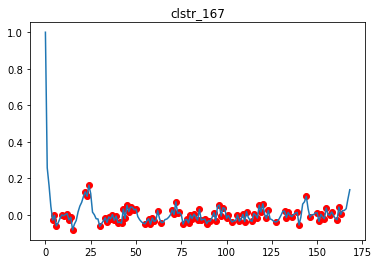

peak index: [  7   9  10  12  14  15  16  19  20  23  26  27  30  31  32  33  34  35
  36  38  40  43  44  45  46  49  52  53  54  55  57  58  60  61  63  64
  65  66  67  69  70  72  73  74  79  81  84  85  87  88  90  92  93  96
  98  99 101 102 103 105 106 107 108 111 113 114 115 117 118 120 123 124
 125 126 127 129 130 132 134 135 137 138 139 143 145 146 147 148 149 150
 151 152 154 157 159 160 161 162 163]


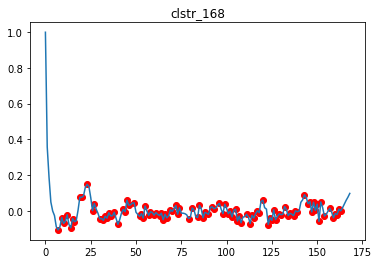

peak index: [  6   9  11  12  14  16  17  19  20  21  22  23  32  34  37  39  40  41
  42  44  45  48  49  50  55  58  61  63  64  66  67  69  71  72  73  74
  75  77  79  81  82  83  85  86  87  88  89  90  91  93  94  96  98 100
 101 102 103 105 107 109 110 112 113 114 116 117 118 119 120 122 123 125
 126 130 131 132 133 136 137 139 140 142 143 144 145 147 148 149 150 152
 153 155 156 157 158 160 161 162 163 167]


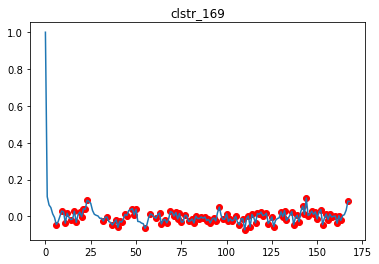

peak index: [  4   5   7   8   9  10  11  12  13  16  17  18  19  21  22  24  27  29
  32  33  35  37  38  39  41  44  45  48  51  56  57  59  60  61  62  64
  65  66  67  68  70  71  74  75  76  77  78  80  81  82  85  87  88  89
  90  92  93  95  97  98  99 102 104 105 108 109 110 111 113 114 116 119
 122 123 124 125 126 128 129 130 133 135 136 138 139 140 141 143 146 147
 149 153 154 157 161 165 166 167]


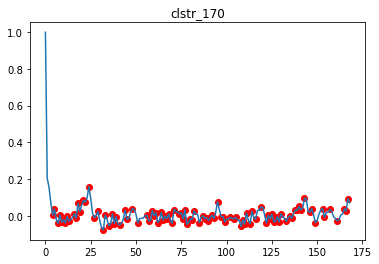

peak index: [  4   5   8  10  11  13  15  18  19  23  28  30  33  35  36  37  38  40
  41  42  43  46  47  48  51  54  55  56  57  59  63  64  67  68  69  72
  76  78  79  82  85  86  88  91  92  93  94  95  97  98  99 100 101 102
 104 106 107 108 111 114 115 116 117 120 123 126 127 128 130 131 134 135
 138 142 146 147 150 151 153 154 155 156 158 163 164 166 167]


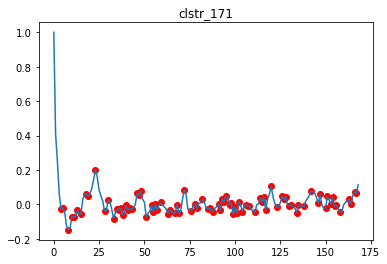

peak index: [  8  11  12  13  14  17  18  20  21  22  23  24  27  28  30  31  32  33
  35  39  40  41  42  44  47  48  50  52  55  57  61  62  63  67  69  70
  71  72  74  75  77  80  81  82  84  86  88  89  90  91  94  96  97  98
  99 100 101 102 104 107 108 110 111 113 114 120 121 123 124 125 127 128
 129 130 131 133 135 136 138 143 144 145 147 151 154 155 156 157 158 160
 162 163 164]


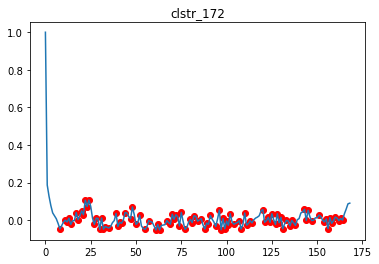

peak index: [  6   7   8   9  10  11  12  15  16  19  20  21  22  24  26  27  32  35
  36  37  38  39  40  41  42  43  44  46  47  48  50  52  55  56  57  58
  60  61  63  65  66  67  68  70  71  72  75  77  79  81  82  84  85  86
  88  90  91  92  94  95  97  98  99 101 102 103 104 108 110 111 114 117
 118 120 121 122 123 126 128 129 131 132 133 135 136 137 139 141 142 144
 145 146 147 148 149 150 151 152 153 156 157 158 161 162 163 165 166]


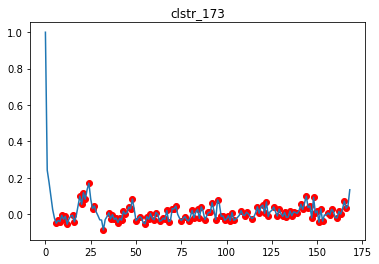

peak index: [  4   5   7   8   9  10  11  13  14  15  17  18  19  21  22  24  26  27
  29  31  32  33  34  36  41  44  45  48  50  51  52  53  55  56  59  60
  61  62  65  67  69  72  74  75  77  78  79  80  82  83  84  86  87  89
  91  92  93  96  98  99 100 101 102 103 104 106 107 108 109 110 111 112
 113 115 117 120 123 124 127 129 131 132 133 136 137 138 141 144 145 147
 148 150 151 152 153 155 156 157 158 160 161 162 163]


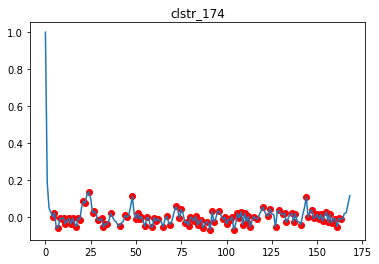

peak index: [  6   9  11  12  13  15  16  17  18  19  20  24  27  28  30  32  33  34
  36  37  38  39  40  41  42  43  45  47  51  52  53  54  55  56  58  59
  60  61  65  66  68  72  74  75  77  79  80  82  83  84  85  86  88  89
  90  91  92  95  99 100 101 106 107 108 109 110 111 112 114 116 118 119
 122 124 125 126 128 129 130 132 133 134 135 138 139 140 141 144 145 146
 147 150 152 153 154 155 156 157 160 161 162 163 164]


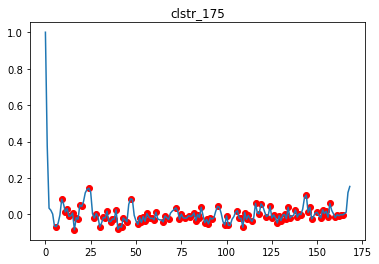

In [38]:
###### PACF plot of ALL numerical time series ###### 
peak_idx_pacf = np.array([])
view_lags = 168
for c in col_names:
    pacf1 = pacf(all_num_ts[c], nlags=view_lags)
    peak_idx_high = np.array((find_peaks(pacf1,height=(-0.4,0.4))[0]),dtype=int)
    peak_idx_low = np.array((find_peaks(-1*pacf1,height=(-0.4,0.4))[0]),dtype=int)
    peak_idx_pacf = np.sort(np.concatenate((peak_idx_high, peak_idx_low),axis=0))
    print(f'peak index: {peak_idx_pacf}')
    x = list(range(0,len(pacf1)))
    plt.plot(x,pacf1)
    plt.scatter(peak_idx_high,pacf1[peak_idx_high],color='red')
    plt.scatter(peak_idx_low,pacf1[peak_idx_low],color='red')
    plt.title(c)
    plt.show()

# use peak_idx_pacf to pick the first 50 lags

###### PACF plot of ALL numerical time series ######

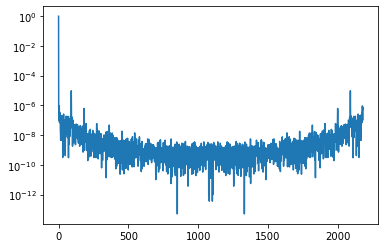

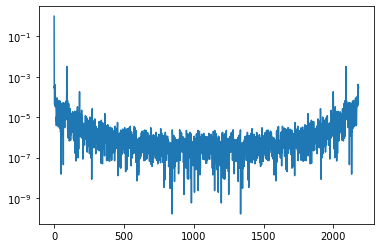

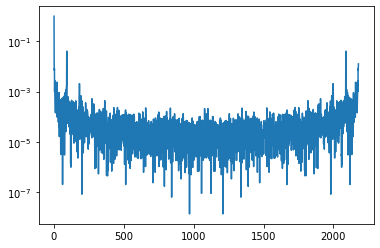

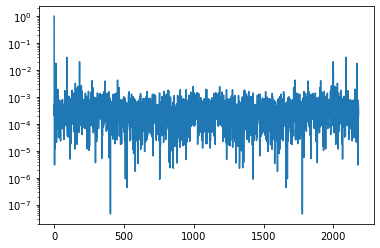

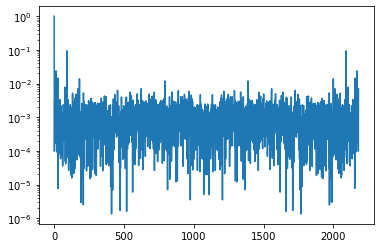

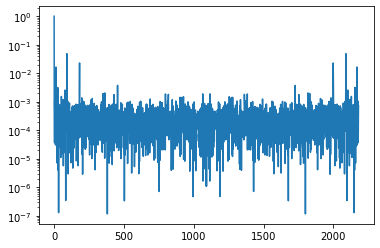

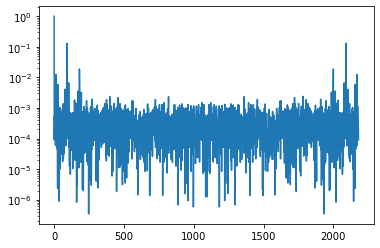

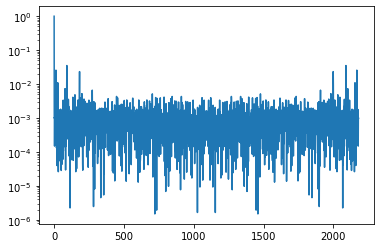

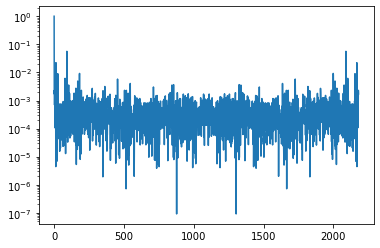

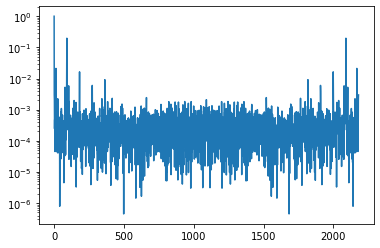

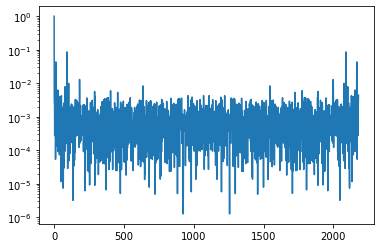

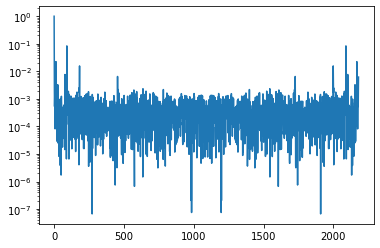

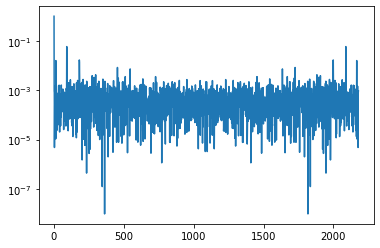

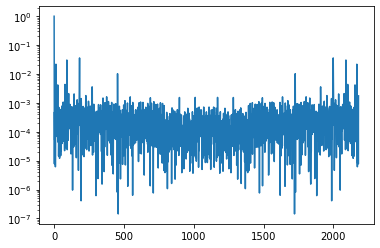

In [39]:
###### FFT plot of ALL numerical time series ###### 
for c in col_names:
    # apply fast fourier transform and take absolute values
    f=abs(np.fft.fft(all_num_ts[c]))
    # get the list of frequencies
    num=(len(f))
    freq = [i for i in list(range(num))]
    # get the list of spectrums
    spectrum=f.real*f.real+f.imag*f.imag
    nspectrum=spectrum/spectrum[0]
    # plot nspectrum per frequency, with a semilog scale on nspectrum
    plt.semilogy(freq,nspectrum)
    plt.show()
###### FFT plot of ALL numerical time series ###### 

correlation between clstr_126,and clstr_175 for 168 lags


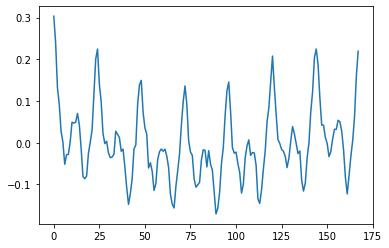

correlation between clstr_166,and clstr_175 for 168 lags


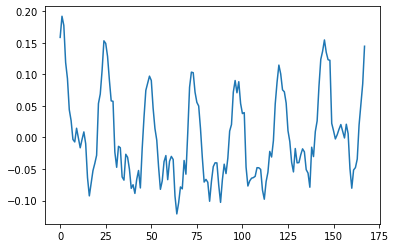

correlation between clstr_167,and clstr_175 for 168 lags


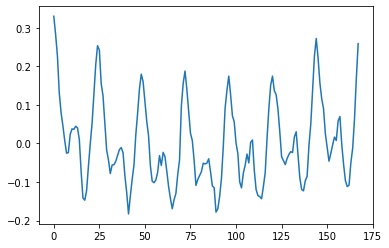

correlation between clstr_168,and clstr_175 for 168 lags


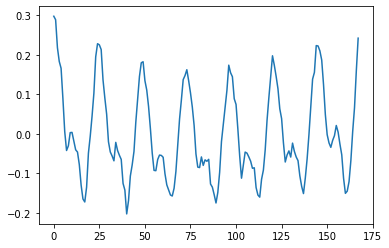

correlation between clstr_169,and clstr_175 for 168 lags


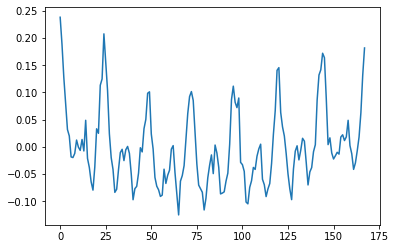

correlation between clstr_170,and clstr_175 for 168 lags


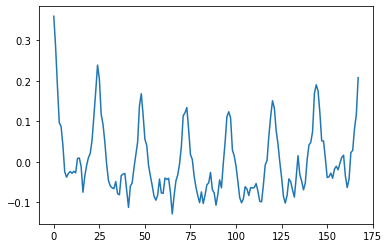

correlation between clstr_171,and clstr_175 for 168 lags


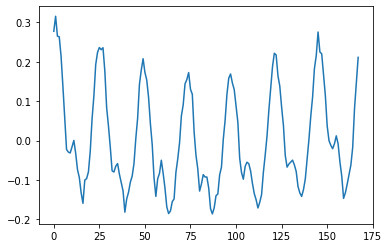

correlation between clstr_172,and clstr_175 for 168 lags


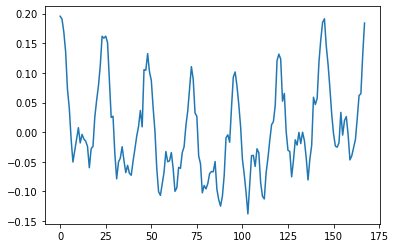

correlation between clstr_173,and clstr_175 for 168 lags


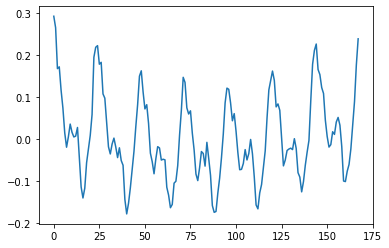

correlation between clstr_174,and clstr_175 for 168 lags


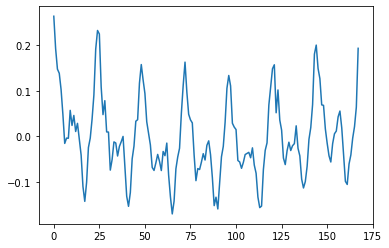

new covariate clusters columns: ['clstr_171', 'clstr_168']


In [40]:
###### Cross correlation plot of ALL demand time series ###### 
'''
# ########## calculate cross correlation between any 2 clusters ##########
# ## create all pairs of cluster demand_data in this region
# all_combi_idx = list(combinations(range(len(list(col_names))-3),2))
# all_demand_cols = list(col_names)[3:] # remove temp, hum, & wind speed
# for i,j in all_combi_idx:
#     ccf1 = sm.tsa.stattools.ccf( all_num_ts[all_demand_cols[i]],  all_num_ts[all_demand_cols[j]], adjusted=False)
#     print(f'correlation between {all_demand_cols[i]},and {all_demand_cols[j]}')
#     plt.plot(ccf1)
#     plt.show()
# ########## calculate cross correlation between any 2 clusters ##########
'''

# ########## calculate cross correlation between chosen cluster and other clusters ##########
all_other_dem_cols = list(col_names)[3:-1] # remove temp, hum, & wind speed
sum_ccf = {} # find which two series has the highest cross correaltion
first_nlags =168
for c in all_other_dem_cols:
    #calculate cross correlation between any 2 clusters
    ccf1 = sm.tsa.stattools.ccf( all_num_ts[chosen_clstr],  all_num_ts[c], adjusted=False)
    sum_ccf[c + " & " + chosen_clstr] = sum(abs(ccf1[:first_nlags]))
    print(f'correlation between {c},and {chosen_clstr} for {first_nlags} lags')
    plt.plot(ccf1[:first_nlags])
    plt.show()
# ########## calculate cross correlation between chosen cluster and other clusters ##########

ccf_sorted = dict( sorted(sum_ccf.items(), key=operator.itemgetter(1),reverse=True))

new_covariate_clstr_columns = list(ccf_sorted.keys())[:2] # use the 2 largest CCF clusters as covariates for chosen cluster
new_covariate_clstr_columns = [new_covariate_clstr_columns[0].split(" &")[0] , new_covariate_clstr_columns[1].split(" &")[0]]
print(f'new covariate clusters columns: {new_covariate_clstr_columns}')
###### Cross correlation plot of ALL demand time series ###### 

In [ ]:

################# Final numerical covariates and response time series  ###############
final_response_ts = {chosen_clstr:all_num_ts[chosen_clstr]}
final_num_covariate_ts = {'temp_clstr_175':temp_clstr_175,'hum_clstr_175':hum_clstr_175, 'wind_clstr_175':wind_clstr_175}

print('final_response_ts', final_response_ts)
print('final_num_covariate_ts', final_num_covariate_ts)

with open("final_response_ts.pkl",'wb') as f:
    pickle.dump(final_response_ts,f)

with open("final_num_covariate_ts.pkl",'wb') as f:
    pickle.dump(final_num_covariate_ts,f)

################# Final numerical covariates and response time series  ###############


In [ ]:
###############
# TODO CHECK that each hour of any 24 hour random period can be modelled by a negative binomial distribution
# check the goodness of fit. 

################

In [42]:
################# Final categorical covariates time series  ###############
final_cat_covariate_ts = {"wea_clstr_175":tampines_region_weather["wea_clstr_175"].astype(dtype=str),"wea_desc_clstr_175":tampines_region_weather["wea_desc_clstr_175"].astype(dtype=str)}

for c in new_covariate_clstr_columns:
    final_cat_covariate_ts[c] = all_num_ts[c].astype(str)

with open("final_cat_covariate_ts.pkl",'wb') as f:
    pickle.dump(final_cat_covariate_ts,f)
################# Final categorical covariates time series  ###############
